# Bistable neuron

As a conceptual model of a bistable neuron, let's use an equation that has two stable states (duh):

$$\frac{dy}{dt} = K[\sigma(a(x-I_\text{threshold})) - y]$$

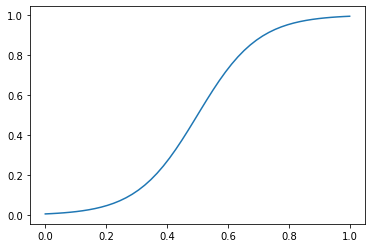

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

def s(x, slope, bias):
    return expit((x + bias)*slope)
    #return 1/(1+np.exp(-(x + bias)*slope))

T = np.linspace(0, 1)
I = np.linspace(0, 1)
#plt.plot(I, s(I, 100, -0.5))
#plt.plot(I, s(I, -100, -0.5))
plt.plot(I, s(I, 10, -0.5))
plt.show()

(15, 15)


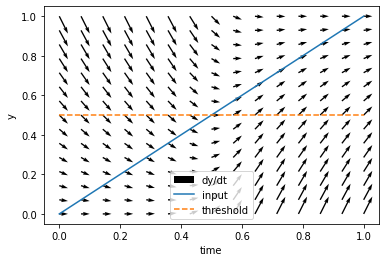

In [9]:
I = interp1d(T, T)

def bistable(I, I_threshold, K, i = None, slope=20):
    return lambda t, x: K*(s(I(t, x), slope, -I_threshold) - (x[i] if i is not None else x))

# Construct a neuron in terms of its derivative
I_threshold = 0.5
neuron = bistable(lambda t, x: I(t), I_threshold, 2)

# Sample its behaviour to draw the vector field
xs = np.linspace(0, 1, 15)
field = np.array([neuron(t, xs) for t in xs])
print(field.shape)

# Plot vector field, input and threshold
u, v = np.meshgrid(xs, xs)
plt.quiver(u, v, 1.0, field.T, label="dy/dt")
plt.plot(T, I(T), label="input")
plt.plot(T, np.ones(T.shape) * I_threshold, '--', label="threshold")
plt.xlabel("time")
plt.ylabel("y")
plt.legend()
plt.show()

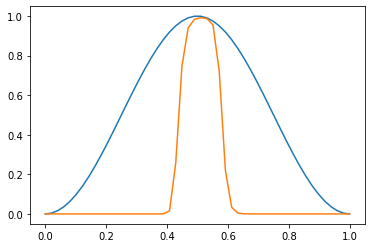

In [10]:
# Let's solve for a cosine input:
I = (-np.cos(2*np.pi*T) + 1.0) * 0.5
I = interp1d(T, I)

neuron = bistable(lambda t, x: I(t), 0.95, 100, slope=100)

solution = solve_ivp(neuron, (0, 1), np.array([0]), t_eval=T)

plt.plot(T, I(T))
plt.plot(solution.t, solution.y[0])
plt.show()

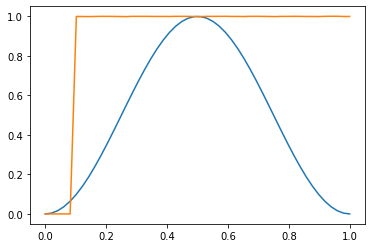

In [11]:
# And then let's do the same with a recurrence:
I = (-np.cos(2*np.pi*T) + 1.0) * 0.5
I = interp1d(T, I)

# Recurrence gain:
h = 1.0

neuron = bistable(lambda t, x: I(t) + h*x, 0.0909, 1000, slope=1000)

solution = solve_ivp(neuron, (0, 1), np.array([0]), t_eval=T)

plt.plot(T, I(T))
plt.plot(solution.t, solution.y[0])
plt.show()

A counter network consists of $N$ of these cells with varying thresholds, all recurrently connected to each-other with equal weights ($h$), and all receiving the same external input $I$ (the same setup as in Koulakov, 2002).

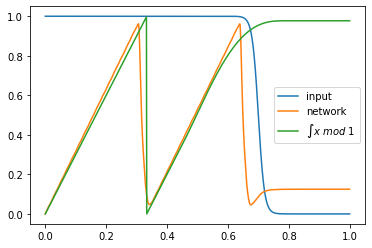

In [12]:
T = np.linspace(0, 1, 1000)
N = 17
I_scale = 0.03
K=100
h=1.0

#I_thresholds = np.linspace(0, 1, N+2)[1:-1]
I_thresholds = np.flip(1-np.linspace(0, 1, N, endpoint=False)) - .5/N
#print(I_thresholds[-1])
neurons = [bistable(lambda t, x: I(t)*I_scale + h*np.sum(x)/N - x[-1], I_thresholds[i], K, i, slope=100) for i in range(N-1)]
neurons.append(bistable(lambda t, x: I(t)*I_scale + h*np.sum(x[:-1])/N + 0.8*x[-1], I_thresholds[-1], 200, N-1, slope=100))

#I = np.ones(T.shape) #(-np.cos(6*np.pi*T) + 1.0) * 0.5
I = 1-expit(100*(T - 0.7))# + expit(100*(T-0.8))
I = interp1d(T, I)

solution = solve_ivp(lambda t, x: np.array([neuron(t, x) for neuron in neurons]), (0, 1), np.zeros(N), t_eval=T)
reference = solve_ivp(lambda t, x: I(t)*I_scale, (0, 1), np.array([0]), t_eval=T).y[0] * 1.0 * K % 1.0

plt.plot(T, I(T), label="input")
plt.plot(solution.t, np.sum(solution.y, 0)/(N-1), label="network")
plt.plot(T, reference, label="$\int x~mod~1$")
plt.legend()
plt.show()

Let's try to set up a residue number system with these counters, with periods of 11, 13 and 17:

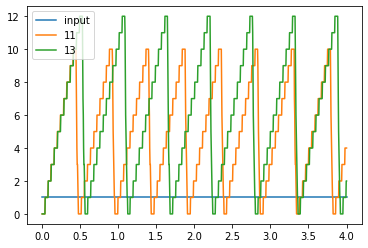

In [26]:
t0 = 0
tf = 4
T = np.linspace(t0, tf, 1000)

def counter(N, I):
    I_scale = (0.03 * 11) / N
    K=100 - N*2

    I_thresholds = np.flip(1-np.linspace(0, 1, N, endpoint=False)) - .5/N
    neurons = [bistable(lambda t, x: I(t)*I_scale + h*np.sum(x)/N - x[-1]*2, I_thresholds[i], K, i, slope=100) for i in range(N-1)]
    neurons.append(bistable(lambda t, x: I(t)*I_scale + h*np.sum(x[:-1])/N + 0.8*x[-1], I_thresholds[-1], 200, N-1, slope=200))
    
    solution = solve_ivp(lambda t, x: np.array([neuron(t, x) for neuron in neurons]), (t0, tf), np.zeros(N), t_eval=T)
    return np.sum(solution.y, 0) / (N-1)
    
I = np.ones(T.shape) #(-np.cos(6*np.pi*T) + 1.0) * 0.5
#I = 1-expit(100*(T - 0.7))# + expit(100*(T-0.8))
I = interp1d(T, I)

#solution = solve_ivp(lambda t, x: np.array([neuron(t, x) for neuron in neurons]), (0, 1), np.zeros(N), t_eval=T)
#reference = solve_ivp(lambda t, x: I(t), (0, 1), np.array([0]), t_eval=T).y[0] * K

n11 = np.floor(11*counter(11, I))
n13 = np.floor(13*counter(13, I))

plt.plot(T, I(T), label="input")
plt.plot(T, n11, label="11")
plt.plot(T, n13, label="13")
#plt.plot(solution.t, np.floor(17*counter(17, I)), label="17")
#plt.plot(T, reference * (0.03 * 11) / 11 % 1.0, label="$\int x~mod~11$")
#plt.plot(T, reference * (0.03 * 11) / 13 % 1.0, label="$\int x~mod~13$")
#plt.plot(T, reference * (0.03 * 11) / 17 % 1.0, label="$\int x~mod~17$")
plt.legend()
plt.show()

We decode the RNS number using [Bézout's identity](https://en.wikipedia.org/wiki/Chinese_remainder_theorem#Case_of_two_moduli):

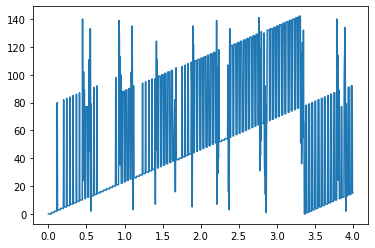

In [27]:
m1=6
m2=-5
x = (n11*13*m2 + n13*11*m1) % (11*13)
plt.plot(T, x)